In [ ]:
import sys
import os
import subprocess
from pathlib import Path
from typing import List, Tuple, Dict, Any, Union
import numpy as np
import cv2
import matplotlib.pyplot as plt
%load_ext autoreload

array([[ 6.06966330e-01,  2.55776572e-02,  5.12149417e+02],
       [-1.35793307e-01,  8.83077758e-01,  4.04200519e+01],
       [-3.32232825e-04,  2.50251930e-06,  1.00000000e+00]])

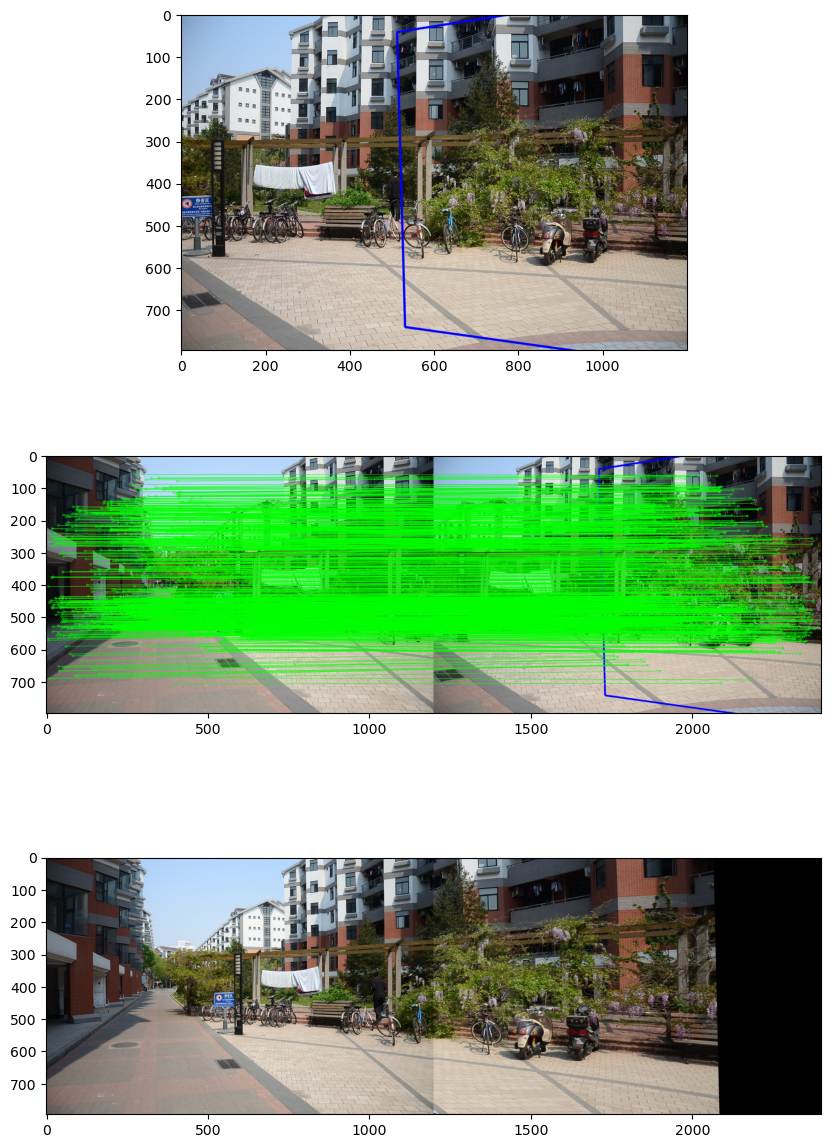

In [199]:
%autoreload 2
import panorama

panorama.main('./', mode='plot')